### Import

Dataset : https://www.kaggle.com/datasets/humansintheloop/semantic-segmentation-of-aerial-imagery

In [1]:
!pip install patchify

In [2]:
!pip install segmentation_models_pytorch

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.7/106.7 kB 3.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 4.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16446 sha256=e1bea36034e722280f39a7574fb2c15fe43cf75b0d229f258549ff9cd0a7d29d
  Stored in directory: /root/.cache/pip/wheels/03/3f/e9/911b1bc46869644912bda90a56bcf7b960f20b5187feea3baf
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-py3-none-any.whl size=60966 sha256=d654ae93205d8a3d9aea10ee17f012cb687bc4c24128d4ea5733520ce005a164
  Stored in directory: /root/.cache/pip/wheels/35/cb/a5/8f534c60142835bfc889f9a482e4a67e0b817032d9c6883b64
Successfully built efficientnet-pytorch pretrainedmodels


In [3]:
import os
import re
from pathlib import Path
import numpy as np
from patchify import patchify
from PIL import Image

In [4]:
import torch
from torch.utils.data import Dataset, DataLoader
import cv2
import segmentation_models_pytorch as smp
import seaborn as sns
import matplotlib.pyplot as plt

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [5]:
import torch.nn as nn

In [6]:
import torchmetrics

/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: libtensorflow_io.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so: undefined symbol: _ZTVN10tenso

### Create patches

In [7]:
def create_folder():
    FOLDERS = ['train','val','test']
    
    for folder in FOLDERS:
        if not os.path.exists(folder):
            folder_imgs = f"{folder}/images"
            folder_msks = f"{folder}/masks"
            os.makedirs(folder_imgs) if not os.path.exists(folder_imgs) else print('folder already exists')
            os.makedirs(folder_msks) if not os.path.exists(folder_msks) else print('folder already exists')

In [8]:
create_folder()

### Create Patches

In [9]:
def create_patches(src, dest_path):
    path_split = os.path.split(src)
    tile_num = re.findall(r'\d+', path_split[0])
    image = Image.open(src)
    image = np.asarray(image)
    if len(image.shape) > 2:
        patches = patchify(image, (320, 320, 3), step = 300)
        file_name_wo_ext = Path(src).stem
        for i in range(patches.shape[0]):
            for j in range(patches.shape[1]):
                patch = patches[i, j, 0]
                num = i * patches.shape[1] + j
                patch = Image.fromarray(patch)
                patch.save(f"{dest_path}/{file_name_wo_ext}_tile_{tile_num}_patch_{num}.png")
                

In [10]:
for path_name, _, file_name in os.walk('/kaggle/input/semantic-segmentation-of-aerial-imagery/Semantic segmentation dataset'):
    for f in file_name:
        print(f)
        if f != 'classes.json':
            path_split = os.path.split(path_name)
            tile_num = re.findall(r'\d+',path_split[0])[0]
            img_type = path_split[1]
            
            if tile_num == '3':
                target_folder_imgs = 'val'
                target_foler_masks = 'val'
            elif tile_num == '1':
                target_folder_imgs = 'test'
                target_foler_masks = 'test'
            elif tile_num in ['4', '5', '6', '7', '8']:
                target_folder_imgs = 'train'
                target_foler_masks = 'train'
                
            # copy all images
            src = os.path.join(path_name, f)
            file_name_wo_ext = Path(src).stem
            
            # Check if file exists in images and masks
            img_file = f"{path_split[0]}/images/{file_name_wo_ext}.jpg"
            mask_file = f"{path_split[0]}/masks/{file_name_wo_ext}.png"
            
            if os.path.exists(img_file) and os.path.exists(mask_file):
                if img_type == 'images':
                    dest = os.path.join(target_folder_imgs, img_type)
                    create_patches(src, dest)
                
                if img_type == 'masks':
                    dest = os.path.join(target_foler_masks, img_type)
                    create_patches(src, dest)                

classes.json
image_part_002.jpg
image_part_006.jpg
image_part_005.jpg
image_part_003.jpg
image_part_004.jpg
image_part_007.jpg
image_part_009.jpg
image_part_008.jpg
image_part_001.jpg
image_part_001.png
image_part_003.png
image_part_006.png
image_part_002.png
image_part_008.png
image_part_007.png
image_part_009.png
image_part_005.png
image_part_004.png
image_part_002.jpg
image_part_006.jpg
image_part_005.jpg
image_part_003.jpg
image_part_004.jpg
image_part_007.jpg
image_part_009.jpg
image_part_008.jpg
image_part_001.jpg
image_part_001.png
image_part_003.png
image_part_006.png
image_part_002.png
image_part_008.png
image_part_007.png
image_part_009.png
image_part_005.png
image_part_004.png
image_part_002.jpg
image_part_006.jpg
image_part_005.jpg
image_part_003.jpg
image_part_004.jpg
image_part_007.jpg
image_part_009.jpg
image_part_008.jpg
image_part_001.jpg
image_part_001.png
image_part_003.png
image_part_006.png
image_part_002.png
image_part_008.png
image_part_007.png
image_part_009.png

### Create Dataset class

In [11]:
mask_names = os.listdir("/kaggle/working/train/masks")

In [12]:
mask_paths = [f"/kaggle/working/train/masks/{i}" for i in mask_names]

In [13]:
mask_paths[0]

"/kaggle/working/train/masks/image_part_004_tile_['8']_patch_17.png"

In [14]:
mask = cv2.imread(mask_paths[0], 0)

In [15]:
mask

array([[172, 172, 172, ...,  44,  44,  44],
       [172, 172, 172, ...,  44,  44,  44],
       [172, 172, 172, ...,  44,  44,  44],
       ...,
       [ 44,  44,  44, ..., 212, 212, 212],
       [ 44,  44,  44, ..., 212, 212, 212],
       [ 44,  44,  44, ..., 212, 212, 212]], dtype=uint8)

In [16]:
mask[mask==91] = 2

In [17]:
mask

array([[172, 172, 172, ...,  44,  44,  44],
       [172, 172, 172, ...,  44,  44,  44],
       [172, 172, 172, ...,  44,  44,  44],
       ...,
       [ 44,  44,  44, ..., 212, 212, 212],
       [ 44,  44,  44, ..., 212, 212, 212],
       [ 44,  44,  44, ..., 212, 212, 212]], dtype=uint8)

In [18]:
def convert_mask(mask):
    mask[mask == 155] = 0 # unlabelled
    mask[mask == 44] = 1 # building
    mask[mask == 91] = 2 # land
    mask[mask == 171] = 3 # water
    mask[mask == 172] = 4 # road
    mask[mask == 212] = 5 # vegetation
    return mask

In [19]:
mask = convert_mask(mask)

In [20]:
mask

array([[4, 4, 4, ..., 1, 1, 1],
       [4, 4, 4, ..., 1, 1, 1],
       [4, 4, 4, ..., 1, 1, 1],
       ...,
       [1, 1, 1, ..., 5, 5, 5],
       [1, 1, 1, ..., 5, 5, 5],
       [1, 1, 1, ..., 5, 5, 5]], dtype=uint8)

In [21]:
class SegmentationDataset(Dataset):
    
    def __init__(self, path_name) -> None:
        super().__init__()
        self.image_names = os.listdir(f"{path_name}/images")
        self.image_paths = [f"{path_name}/images/{i}" for i in self.image_names]
        self.mask_names = os.listdir(f"{path_name}/masks")
        self.mask_paths = [f"{path_name}/masks/{i}" for i in self.mask_names]
        
        # filter all images that do not exists in both folder
        self.img_stem = [Path(i).stem for i in self.image_paths]
        self.msk_stem = [Path(i).stem for i in self.mask_paths]
        
        self.img_msk_stem = set(self.img_stem) & set(self.msk_stem)
        
        self.image_paths = [i for i in self.image_paths if (Path(i).stem in self.img_msk_stem)]

    
    def __len__(self):
        return len(self.img_msk_stem)
    
    def convert_mask(self, mask):
        mask[mask == 155] = 0 # unlabelled
        mask[mask == 44] = 1 # building
        mask[mask == 91] = 2 # land
        mask[mask == 171] = 3 # water
        mask[mask == 172] = 4 # road
        mask[mask == 212] = 5 # vegetation
        return mask
    
    def __getitem__(self, index):
        image = cv2.imread(self.image_paths[index])
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        
        image = image.transpose((2, 0, 1))
        mask = cv2.imread(self.mask_paths[index], 0)
        mask = self.convert_mask(mask)
        return image, mask
        
        

### Modelling Setup

In [22]:
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

In [23]:
DEVICE

'cuda'

In [24]:
EPOCHS = 25

In [25]:
BATCH_SIZE = 4

In [26]:
# Create dataloader
train_ds = SegmentationDataset(path_name = '/kaggle/working/train')
train_dataloader = DataLoader(train_ds, batch_size = BATCH_SIZE, shuffle = True)
val_ds = SegmentationDataset(path_name = '/kaggle/working/test')
val_dataloader = DataLoader(val_ds, batch_size = BATCH_SIZE, shuffle = True)

In [27]:
train_ds[0]

(array([[[ 64,  59,  46, ...,  55,  58, 141],
         [ 37,  36,  38, ...,  67,  64,  78],
         [ 36,  41,  52, ...,  67,  79,  77],
         ...,
         [ 87, 105, 111, ...,  64,  85,  39],
         [ 45,  83, 108, ...,  42,  78,  63],
         [  9,  62, 100, ...,  43,  81,  87]],
 
        [[ 54,  49,  36, ...,  59,  62, 145],
         [ 27,  27,  28, ...,  71,  68,  82],
         [ 27,  32,  43, ...,  69,  81,  79],
         ...,
         [ 84, 102, 108, ...,  61,  82,  36],
         [ 39,  80, 105, ...,  39,  74,  60],
         [  3,  57,  97, ...,  39,  77,  83]],
 
        [[ 63,  58,  45, ...,  62,  65, 148],
         [ 35,  32,  36, ...,  72,  67,  81],
         [ 32,  35,  48, ...,  64,  78,  76],
         ...,
         [ 95, 113, 119, ...,  54,  77,  29],
         [ 49,  89, 114, ...,  34,  71,  55],
         [ 13,  64, 104, ...,  38,  76,  82]]], dtype=uint8),
 array([[4, 4, 4, ..., 1, 1, 1],
        [4, 4, 4, ..., 1, 1, 1],
        [4, 4, 4, ..., 1, 1, 1],
        .

### Modelling

In [28]:
model = smp.FPN(
    encoder_name = "resnext50_32x4d",
    encoder_weights = "imagenet",
    classes = 6,
)

Downloading: "https://download.pytorch.org/models/resnext50_32x4d-7cdf4587.pth" to /root/.cache/torch/hub/checkpoints/resnext50_32x4d-7cdf4587.pth
100%|██████████| 95.8M/95.8M [00:02<00:00, 47.8MB/s]


In [29]:
model.to(DEVICE)

FPN(
  (encoder): ResNetEncoder(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
        (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(128, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Se

In [30]:
optimizer = torch.optim.Adam([dict(params = model.parameters(), lr = 0.0001)])

In [31]:
criterion = nn.CrossEntropyLoss()

### Training

In [32]:
train_losses, val_losses = [], []

In [33]:
for e in range(EPOCHS):
    model.train()
    
    running_train_loss, running_val_loss = 0, 0
    
    for i, data in enumerate(train_dataloader):
        image_i, mask_i = data
        image = image_i.to(DEVICE)
        mask = mask_i.to(DEVICE)
        
        # reset gradients
        optimizer.zero_grad()
        
        # Forward pass
        output = model(image.float())
        
        # Calculate loss
        train_loss = criterion(output.float(), mask.long())
        
        # backpropagation
        train_loss.backward()
        optimizer.step()
        
        running_train_loss += train_loss
    train_losses.append(running_train_loss)
    
    
    # Validation
    model.eval()
    with torch.no_grad():
        for i, data in enumerate(val_dataloader):
            image_i, mask_i = data
            image = image_i.to(DEVICE)
            mask = mask_i.to(DEVICE)
            
            output = model(image.float())
            
            val_loss = criterion(output.float(), mask.long())
            running_val_loss += val_loss.item()
        
        val_losses.append(running_val_loss)
        print(f"Epoch : {e}, Train Loss : {running_train_loss}, Val Loss : {running_val_loss}")

Epoch : 0, Train Loss : 203.00965881347656, Val Loss : 6.415701270103455
Epoch : 1, Train Loss : 118.02729797363281, Val Loss : 6.5058973133563995
Epoch : 2, Train Loss : 99.3422622680664, Val Loss : 6.160939037799835
Epoch : 3, Train Loss : 86.44918823242188, Val Loss : 5.891378819942474
Epoch : 4, Train Loss : 73.64063262939453, Val Loss : 5.26385372877121
Epoch : 5, Train Loss : 66.22523498535156, Val Loss : 5.814988911151886
Epoch : 6, Train Loss : 62.62709426879883, Val Loss : 6.027350336313248
Epoch : 7, Train Loss : 73.07496643066406, Val Loss : 5.260288894176483
Epoch : 8, Train Loss : 59.9297981262207, Val Loss : 5.534660309553146
Epoch : 9, Train Loss : 58.05317306518555, Val Loss : 5.32724267244339
Epoch : 10, Train Loss : 50.628971099853516, Val Loss : 5.331890285015106
Epoch : 11, Train Loss : 51.160404205322266, Val Loss : 5.221592336893082
Epoch : 12, Train Loss : 47.4885139465332, Val Loss : 5.573275536298752
Epoch : 13, Train Loss : 42.71468734741211, Val Loss : 6.2132

### Visaulizing losses

In [38]:
train_losses = [tensor.cpu().detach().numpy() for tensor in train_losses]
#val_losses = [tensor.cpu() for tensor in val_losses]

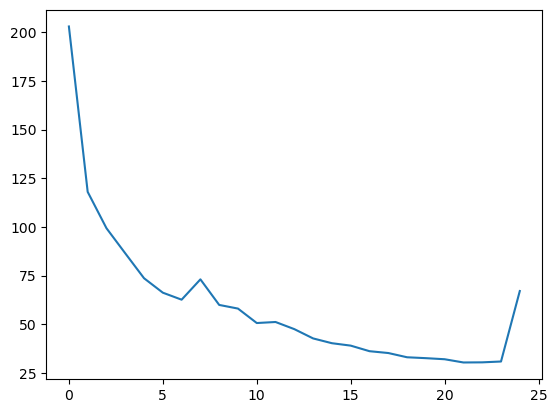

In [42]:
plt.plot(train_losses)

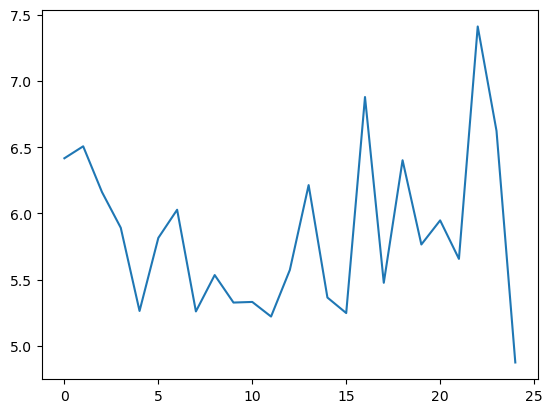

In [43]:
plt.plot(val_losses)

### Save Model

In [44]:
os.mkdir("models")

In [45]:
torch.save(model.state_dict(), f"/kaggle/working/models/FPN_{EPOCHS}_epochs_state_dict.pth")

### Model Eval

In [47]:
test_ds = SegmentationDataset(path_name = "/kaggle/working/test")
test_dataloader = DataLoader(test_ds, batch_size = 1, shuffle = True)

In [48]:
model = smp.FPN(
    encoder_name = "resnext50_32x4d",
    encoder_weights = "imagenet",
    classes = 6,
)

In [49]:
model.to(DEVICE)

FPN(
  (encoder): ResNetEncoder(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
        (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(128, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Se

In [50]:
model.load_state_dict(torch.load('/kaggle/working/models/FPN_25_epochs_state_dict.pth'))

<All keys matched successfully>

In [51]:
pixel_accuracies = []
intersection_over_unions = []

metric_iou = torchmetrics.JaccardIndex(num_classes = 6, task = "multiclass").to(DEVICE)

In [56]:
with torch.no_grad():
    
    for data in test_dataloader:
        inputs, outputs = data
        true_values = outputs.to(torch.float32)
        pred_values = model(inputs.to(DEVICE).float())
        predicted_class = torch.max(pred_values, 1)[1]
        true_values = true_values.to(DEVICE)
        correct_pixels = (true_values == predicted_class).sum().item()
        total_pixels = true_values.size(1) * true_values.size(2)
        pixel_accuracies.append(correct_pixels / total_pixels)
        
        iou = metric_iou(predicted_class.float(), true_values).item()
        intersection_over_unions.append(iou)

In [58]:
print(f"Median Pixel Accuracy : {np.median(pixel_accuracies) * 100}")
print(f"Median IOU : {np.median(intersection_over_unions) * 100}")

Median Pixel Accuracy : 83.091796875
Median IOU : 30.056264996528625


## Checking Outputs

In [59]:
image_test, mask = next(iter(test_dataloader))

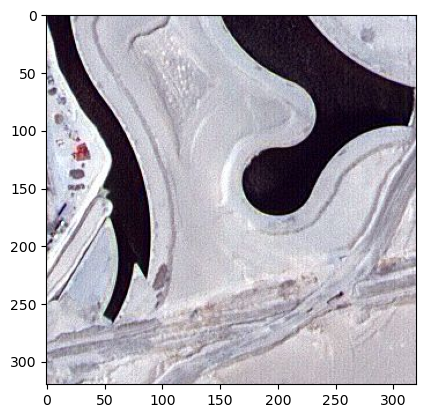

In [60]:
# Original Image
plt.imshow(np.transpose(image_test[0, :, :, :].cpu().numpy(), (1, 2, 0)))

In [61]:
# predict
with torch.no_grad():
    image_test = image_test.float().to(DEVICE)
    output = model(image_test)

In [62]:
output_cpu = output.cpu().squeeze().numpy()

In [63]:
output_cpu = output_cpu.transpose((1, 2, 0))

In [64]:
output_cpu = output_cpu.argmax(axis = 2)

Text(0.5, 1.0, 'Predicted Mask')

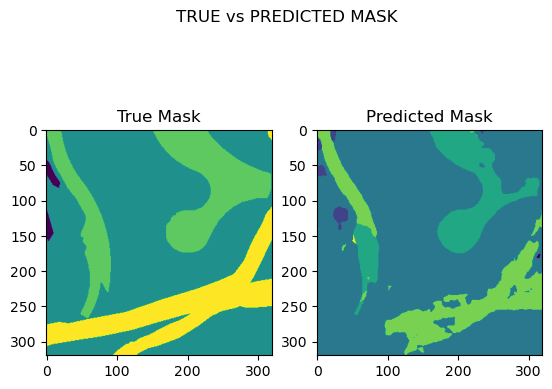

In [67]:
fig, ax = plt.subplots(nrows = 1, ncols = 2)
fig.suptitle('TRUE vs PREDICTED MASK')
ax[0].imshow(mask[0, :, :])
ax[1].imshow(output_cpu)
ax[0].set_title("True Mask")
ax[1].set_title("Predicted Mask")